In [81]:
import pandas as pd
import movingpandas as mpd
import matplotlib.pyplot as plt
import sys
import plotly.express as px
import folium
from folium import plugins
import numpy as np
from datetime import datetime
from folium.features import DivIcon
import geopandas
from datetime import datetime, timedelta
from tqdm import tqdm

df = pd.read_csv('../../data/pos.csv')

In [2]:
# Check if mmsi is from a Tugboat; This is done by checking if the ship ever enters the
# 'Schlepperhafen' area
def is_tugboat(lats, lons):
    top_left = (53.553079, 8.560255)
    top_right = (53.553130,8.561651)
    bottom_right = (53.552225,8.561758)
    bottom_left = (53.552250,8.560362)

    return any(lat < top_left[0] and lat > bottom_left[0] and lon > top_left[1] and lon < top_right[1] for lat, lon in zip(lats, lons))


is_tugboat([20, 53.55260666666667], [8.56090166666, 8.56090166666])

True

In [3]:
# df.shape
# remove "standing still in habour"
df = df[df.sog>0]
df = df[(df.lon<180) | (df.lat<90)]
# convert to GeoDataFrame
# TODO differences between crs
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(x=df.lon, y=df.lat), crs="WGS84"
)


In [4]:
gdf['time'] = pd.to_datetime(gdf['time'], unit='s')
gdf = gdf.set_index('time')


In [5]:
# Specify minimum length for a trajectory (in meters)
minimum_length = 30 
collection = mpd.TrajectoryCollection(gdf, 'mmsi', min_length=minimum_length)

In [ ]:
collection.plot()

In [ ]:
collection.add_speed(overwrite=True)
collection.add_direction(overwrite=True)

In [6]:
# Remove Trajectories that have too long gaps in consecutive AIS signals
trips = mpd.ObservationGapSplitter(collection).split(gap=timedelta(minutes=5))
# Remove all anchoring chips with a tolerance of 15 diameter (for example the Schlepper laying in the Schlepperhafen)
trips = mpd.StopSplitter(trips).split(max_diameter=15, min_duration=timedelta(minutes=3), min_length=200)
# Outlier detecting and cleaning (Outlier (interquantile range - iqr) based cleaner.)
# From moving pandas: "Note: Setting alpha=3 is widely used."
trips = mpd.OutlierCleaner(trips).clean({'sog': 3})

In [60]:
trips.add_speed(overwrite=True)
trips.add_direction(overwrite=True)

In [7]:
print(collection)
print(trips)

TrajectoryCollection with 108 trajectories
TrajectoryCollection with 3623 trajectories


In [15]:
original_traj = trips.trajectories[255]
plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
original_traj.plot(column='speed', vmax=20, **plot_defaults)
original_traj.get_duration()
#original_traj.hvplot(frame_height=600, frame_width=1200)

datetime.timedelta(seconds=310)

In [15]:
trips.trajectories[2].plot(column="speed", linewidth=5, capstyle='round', legend=True)

<AxesSubplot:>

In [9]:
def get_row_at(df, t, method):
    try:
      return df.loc[t]
    except KeyError:
      return df.iloc[
        df.index.sort_values().drop_duplicates().get_loc(t, method=method)
     ]
      
def get_speed_at(df, t):
    return _get_column_value_at(df, t, "sog")
    pass
    
def _get_column_value_at(df, t, col):
  try:
      return df.loc[t][col]
  except KeyError:
      prev_row = df.iloc[
        df.index.sort_values().drop_duplicates().get_loc(t, method="ffill")
      ]
      next_row = df.iloc[
        df.index.sort_values().drop_duplicates().get_loc(t, method="bfill")
      ]
      
  # Linear interpolate between the two data points to calculate row by given t
  time_diff = (next_row.name - prev_row.name).total_seconds()
  time_diff_to_t = (t - prev_row.name).total_seconds()
  y = [prev_row[col], next_row[col]]
  x = [0, time_diff]
  print(prev_row[col])
  print(next_row[col])
  return np.interp(time_diff_to_t, x, y)

In [55]:
traj_gdf = trips.to_point_gdf()
traj_gdf.to_file("temp.gpkg", layer='trajectories', driver="GPKG")
redin = geopandas.read_file('temp.gpkg', layer='trajectories')

<AxesSubplot:>

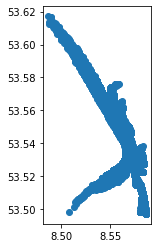

In [56]:
redin.plot()

TrajectoryCollection with 3623 trajectories

In [54]:
%%time
traj_collection = mpd.TrajectoryCollection(redin, 'traj_id')
print(traj_collection)

TrajectoryCollection with 0 trajectories
CPU times: user 113 ms, sys: 21 µs, total: 113 ms
Wall time: 111 ms


In [10]:
start_time = trips.trajectories[3].get_start_time()
print(get_speed_at(trips.trajectories[3].df, start_time + timedelta(seconds=110)))


0.1000000014901161


In [79]:
start_time = trips.trajectories[3].get_start_time()
end_time =  trips.trajectories[3].get_end_time()



    
    
k = trips.trajectories[3].df.resample('5S', origin="end").mean()
#k["sog"].interpolate(method="linear", inplace=True)
#k["cog"].interpolate(method="linear", inplace=True)
k["mmsi"].interpolate(method="bfill", inplace=True)
k["nav_status"].interpolate(method="bfill", inplace=True)
k["day"].interpolate(method="bfill", inplace=True)
#k["lat"].interpolate(method="linear", inplace=True)
#k["lon"].interpolate(method="linear", inplace=True)
plt.scatter(x=k["lon"], y=k["lat"])

k["traj_id"] = str(k["mmsi"][0]) + str(k.iloc[0].name)
k["timestamp"] = k.index

In [96]:
def resample_and_interpolate(trips, resample_interval="5S", interpolate_method="linear"):
    out = pd.DataFrame()

    for t in tqdm(trips.trajectories):
        tmp = t.df.resample(resample_interval, origin="end").mean()
        tmp["mmsi"].interpolate(method="bfill", inplace=True)
        tmp["nav_status"].interpolate(method="bfill", inplace=True)
        tmp["day"].interpolate(method="bfill", inplace=True)
        tmp["sog"].interpolate(method=interpolate_method, inplace=True)
        tmp["cog"].interpolate(method=interpolate_method, inplace=True)
        tmp["lat"].interpolate(method=interpolate_method, inplace=True)
        tmp["lon"].interpolate(method=interpolate_method, inplace=True)
        tmp["traj_id"] = str(tmp["mmsi"][0]) + str(tmp.iloc[0].name)
        tmp["timestamp"] = tmp.index
        tmp.reset_index(drop=True, inplace=True)
        out = out.append(tmp)
        
    return out

100%|██████████| 3623/3623 [00:31<00:00, 114.14it/s]


In [97]:
linear_out = resample_and_interpolate(trips, resample_interval='5S', interpolate_method='linear')
linear_out.to_csv("trajectories_linear_interpolate.csv", index=False)

cubic_out = resample_and_interpolate(trips, resample_interval='5S', interpolate_method='cubic')
cubic_out.to_csv("trajectories_cubic_interpolate.csv", index=False)

In [108]:
print(min(out["lat"]))
print(max(out["lat"]))

53.497218333333336
53.617151666666665


In [29]:
fig = px.scatter_mapbox(trips.trajectories.df, lon="lon", lat="lat", color="mmsi",
                zoom=11, height=800, 
                center={'lat': 53.53, 'lon':8.56})
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

AttributeError: 'list' object has no attribute 'df'

In [3]:
m = folium.Map(location=[53.54, 8.56])
grp = df.groupby(["mmsi", "day"])

In [4]:
for mmsi, day in list(df.groupby(["mmsi", "day"]).groups.keys())[:10]:
    ship = grp.get_group((mmsi, day))
    ship = ship.sort_values(by=['time'])
    past_mole = ship[(ship["lon"] > 8.57603)]
    if len(past_mole) > 0:
        time_passing_mole = past_mole.iloc[0]["time"]
        ship = ship[(ship["time"]< int(time_passing_mole))]
    times = [datetime.utcfromtimestamp(x).strftime('%Y-%m-%dT%H:%M:%SZ') for x in ship["time"]]
    coordinates = np.vstack((ship['lat'], ship['lon'])).T
    if len(coordinates) == 0 or is_tugboat(ship['lat'], ship['lon']):
        continue
    print(f'{mmsi} {day}')
    data_tuples = list(zip(coordinates, times))
    line = folium.PolyLine(coordinates,
        weight=1,
        color="black",
    ).add_to(m)
    attr = {"font-weight": "bold", "font-size": "24"}
    plugins.PolyLineTextPath(line, line_color='#FF0000', line_weight=5, attributes=attr, text="").add_to(m)
    for tuple in data_tuples:
        #folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=1 ).add_to( m )
        folium.CircleMarker(location=[tuple[0][0], tuple[0][1]], radius=2, popup=f'lat:{tuple[0][0]},  lon: {tuple[0][1]}, time: {tuple[1]} mmsi: {mmsi}').add_to(m)
        #folium.Marker(location=[tuple[0][0], tuple[0][1]], icon=DivIcon(icon_size=(150,36), icon_anchor=(-13,0),
        #    html='<div style="font-size: 8pt;">{}</div>'.format(tuple[1]))).add_to(m)
m
#m.save("index2.html")

205146000 19
209275000 18
210621000 24


True

In [4]:
g = df.groupby(["mmsi", "day"])
for i, j in list(df.groupby(["mmsi", "day"]).groups.keys())[:20]:
    print(g.get_group((i,j)))

              mmsi       lon        lat        cog  sog  nav_status  \
1042915  205146000  8.585228  53.503808  95.699997  0.0           3   
1042954  205146000  8.585233  53.503795  95.699997  0.0           3   
1042986  205146000  8.585233  53.503780  95.699997  0.0           3   
1043055  205146000  8.585250  53.503783  95.699997  0.0           3   
1043141  205146000  8.585212  53.503793  95.699997  0.0           3   
...            ...       ...        ...        ...  ...         ...   
1115270  205146000  8.585255  53.503777  36.299999  0.0           3   
1115340  205146000  8.585260  53.503783  36.299999  0.0           3   
1115349  205146000  8.585263  53.503783  36.299999  0.0           3   
1115388  205146000  8.585243  53.503793  36.000000  0.0           3   
1115396  205146000  8.585250  53.503790  36.000000  0.0           3   

               time  day  
1042915  1592689921   19  
1042954  1592689961   19  
1042986  1592690001   19  
1043055  1592690082   19  
1043141  159

In [ ]:
g = df.groupby(["mmsi", "day"])
for i, j in list(df.groupby(["mmsi", "day"]).groups.keys())[:20]:
    g.get_group((i,j))

In [ ]:
import geopandas as gpd
from pandasql import sqldf
import fiona

gdb_db = "../../data/Zone17_2014_10.gdb"
layers = {}
layerlist = fiona.listlayers(gdb_db)
layerlist

In [ ]:
for layer in layerlist:
    print("1")
    layers[layer] = gpd.read_file(gdb_db, driver="FileGDB", layer=layer, rows=500000)

In [ ]:
layers.keys()

vessels = layers['Zone17_2014_10_Vessel']
voyages = layers['Zone17_2014_10_Voyage']
broadcasts = layers['Zone17_2014_10_Broadcast']
broadcasts['lon'] = broadcasts.geometry.x
broadcasts['lat'] = broadcasts.geometry.y
broadcasts.drop("geometry", axis=1, inplace=True)

In [ ]:
sqldf("SELECT VoyageID FROM voyages WHERE Destination == 'CASABLANCA'")

In [ ]:
destination = 'CASABLANCA'
destination_bc = sqldf(f"SELECT * FROM broadcasts WHERE VoyageID IN (SELECT VoyageID FROM voyages);")
destination_bc



In [ ]:
broadcasts.value_counts(['VoyageID'])

# Filter voyages by amount of ais signals received for that tour ("GROUP BY voyageID HAVING COUNT(*) > X")
casts = broadcasts[broadcasts["Destination"] == "CASABLANCA"].groupby("VoyageID").filter(lambda x: len(x) > 500).groupby("VoyageID").sum()
casts


In [ ]:
destination_bc

In [ ]:

fig = px.scatter_mapbox(destination_bc, lon="lon", lat="lat", color="VoyageID", size="VoyageID",
                        size_max=3, zoom=10.5, height=600, opacity=0.6, center={'lat':25, 'lon': -80})
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0, "t":0, "l":0, "b": 0})